<div class="alert alert-block alert-success">
<font color=blue>

## Recommendation Engine - PySpark, MovieLens Dataset

#### 0. Overview

Build a Recommender engine using Python,Spark and ALS (Alternating Lest Square) Matrix Factorization algorithm.

#### 1. Data Collection
- Import and load the dataset
- Use API if needed to collect data

#### 2. Data Exploration & Visualization
- Categorical and Contunuous variables : Identify, Descriptive Statistics
- Check missing values
- Draw visualizations
- Outlier detection
- Relationship between Dependent and Independent variables.
- Relationship among Dependent variables (Correlation matrix).

#### 3. Pre-processing
- Detect and remove null records.
- Detect and remove empty strings.
- Categorical to Numerical Variable conversion (Integer Encoding, One-hot encoding)
- Outlier Removal
- Stratified sampling
- Split data into train/test
- Stopword removal, Stemming, Lemmatization (NLP)

#### 4. Feature Engineering
- Feature Engineering (Create new features from existing variables)
- Feature Selection - Define Dependent Variable (y) and Independent Variable (x)
- Vectorization (TF-IDF)

#### 5. Model Building
- Import - Import the Model.
- Instantiate - Create instance of the Model.
- Fit - Fit the model with training data.
- Predict - Predict Model with test data.

#### 6. Model Evaluation
- Confusion Matrix
- Classification Report
- Accuracy Score
- AUC-ROC Curve

#### 7. Model Prediction with new Data
- Feed new data to the model and check prediction.

#### 8. Conclusion and Recommendations
- (Describe the conclusion and recommendation based on model analysis.)
    
</font>
</div>

<div class="alert alert-block alert-success">
<font color=blue>

### 0. Overview

</font>
</div>

- Consumer Banking Marketing campaigns are aimed at reaching out customers for product marketing. 
- An efficient marketing strategy is to, reach out specific customers with better chances of response.
- Objective of this model is to come up with various Customer features who are likely to respond to this campaign.
- Historical data is taken into account for this analysis, where existing customers responded to the campaign.
- Which customers are more likely to respond to bank’s marketing campaigns?

<div class="alert alert-block alert-success">
<font color=blue>

### 1. Data Collection

</font>
</div>

Data file downloaded from MovieLens website - https://grouplens.org/datasets/movielens/100k/

File Name - u.data

Below are some information about the dataset as mentioned int the source website:
* The dataset consists of 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)
* The full u data set, 100000 ratings by 943 users on 1682 items.
* Each user has rated at least 20 movies.  
* Users and items are numbered consecutively from 1.
* The data is randomly ordered.
* This is a tab separated list of "user id | item id | rating | timestamp."
* The timestamps are unix seconds since 1/1/1970 UTC

In [13]:
# Import Required Libraries
from pyspark.sql import SparkSession   # Establish Spark Session
from pyspark.ml.recommendation import ALS  # Recommendation Algorithm to use
from pyspark.ml.evaluation import RegressionEvaluator  # Evaluate Model

In [14]:
spark = SparkSession.builder.appName('Recommendation').getOrCreate()

Since dataset is a delimited file lets read the file to ensure its downloaded at proper location for us to use.

In [18]:
#df = spark.read.load("/home/pabhijit/data/u.data",format="csv", sep="\t", inferSchema="True", header="False")
df = spark.read.csv("/home/pabhijit/data/movielens_ratings.csv",inferSchema="True", header="True")

In [21]:
#df.describe().show()
df.show()

+-------+------+------+
|movieId|rating|userId|
+-------+------+------+
|      2|   3.0|     0|
|      3|   1.0|     0|
|      5|   2.0|     0|
|      9|   4.0|     0|
|     11|   1.0|     0|
|     12|   2.0|     0|
|     15|   1.0|     0|
|     17|   1.0|     0|
|     19|   1.0|     0|
|     21|   1.0|     0|
|     23|   1.0|     0|
|     26|   3.0|     0|
|     27|   1.0|     0|
|     28|   1.0|     0|
|     29|   1.0|     0|
|     30|   1.0|     0|
|     31|   1.0|     0|
|     34|   1.0|     0|
|     37|   1.0|     0|
|     41|   2.0|     0|
+-------+------+------+
only showing top 20 rows



In [24]:
training, test = df.randomSplit([0.8,0.2])

In [25]:
als = ALS(maxIter=5)

<div class="alert alert-block alert-success">
<font color=blue>

### 2. Data Exploration & Visualization

</font>
</div>

What we observed is the dataset doesnot contain a header row. So we will add headers to identify columns in subsequent operations.

In [24]:
df_data = pd.read_csv('~/data/u.data',delimiter='\t',header=None,names=['userid','itemid','rating','timestamp'])
df_data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Timestamp column is not needed for our analysis, so we will exclude that column and get the other 3 columns to our dataframe.

In [25]:
df_data = df_data.iloc[:,[0,1,2]]
df_data.head()

,userid,itemid,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [26]:
df_data.shape

(100000, 3)

There are 100,000 records and 3 input variables. All are continuous variables.

### 2.1 : Descriptive Statistics - Numerical Variables

Since the UserID and ItemID variables are Identifier, analyzing descriptive statistics for IDs wont add any value. So we will skip this step.

### 2.2 : Descriptive Statistics - Categorical Variables

Column "rating" though its a continuous variable, its logically a category. Hence we may be interested in knowing the distribution of various kinds of ratings.

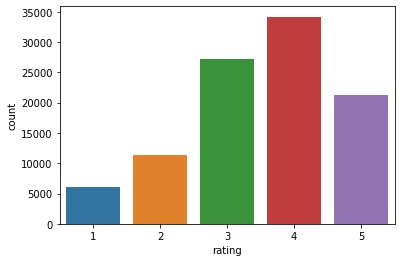

In [28]:
sns.countplot(x="rating", data=df_data);

Looks like around 60% movies are rated 3 or 4.

<div class="alert alert-block alert-success">
<font color=blue>

### 3. Pre-processing

</font>
</div>

### 3.1 : Missing Values Identification

In [29]:
# TOTAL count (non-null values)
sr_count_total = df_data.count()

# MISSING COUNT
sr_count_missing = df_data.isnull().sum()

# MISSING PERCENT
sr_percent_missing = round(df_data.isnull().sum() * 100 / len(df_data),2)

# Total count (non-null values)
df_missing_value = pd.DataFrame({'count_total': sr_count_total,
                                 'count_missing': sr_count_missing,
                                 'percent_missing': sr_percent_missing})

# Sort by the field "percent_missing" descending
df_missing_value.sort_values('percent_missing', ascending=False, inplace=True)

# print the dataframe
df_missing_value

,count_total,count_missing,percent_missing
userid,100000,0,0.0
itemid,100000,0,0.0
rating,100000,0,0.0


NO MISSING VALUES IN THE DATASET.

### 3.2 : Sparsity

* Sparsity provides a measure of how empty a matrix is (or what percentage of the matrix is empty).
* Calculate data sparsity using below sparsity formula, and then we will assess whether further preparation is needed in order to adequately prepare it for ALS.

    Sparsity = (Number of Ratings in Matrix) / (Number of Users) X (Number of Movies)


<div class="alert alert-block alert-success">
<font color=blue>

### 4. Feature Engineering

</font>
</div>

#### Define Dependent Variable (y) and Independent Variable (x)

In [20]:
y = df_data['y'] # We want to predict the response 
x = df_data.drop('y',axis=1) #Excluding "y", rest all are indepdent variables

<div class="alert alert-block alert-success">
<font color=blue>

### 5. Model Building

</font>
</div>

- Split data into Train/Test.

- Compare scores for Various Classification Algorithms:
    - Carry out K-Fold Cross validation with training data.
    - For each fold determine cross validation scores.
    - Finally get the mean score for each algorithm.
    - Pick the best performing algorithm.

- Build Model based on the best performing algorithm.

### 5.2 : Split into Train & Test data subsets

#### 5.2.1 : Random Split

In [21]:
from sklearn.model_selection import train_test_split;

In [83]:
# Reference - https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
# test_size=0.2 => split data into train/test in 70:30 ratio.
# random_state=7 => it will take the same sample every time.

test_size= 0.20
seed = 6

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=test_size,random_state=seed)

In [84]:
print(y_train.value_counts())
print(y_test.value_counts())

0    31963
1     4205
Name: y, dtype: int64
0    7959
1    1084
Name: y, dtype: int64


#### 5.2.2 : Stratified Split (T B D)

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=test_size,random_state=seed,stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

0    31937
1     4231
Name: y, dtype: int64
0    7985
1    1058
Name: y, dtype: int64


In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

In [62]:
test_size= 0.20
seed = 7
n_splits = 1

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=seed)
sss.get_n_splits(x, y)

print(sss)       

for train_index, test_index in sss.split(x, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   #x_train, x_test = x[train_index], x[test_index]
   #y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=1, random_state=7, test_size=0.2,
            train_size=None)
TRAIN: [32167 31569  4404 ... 26438  2425 34167] TEST: [18653 10665  9213 ...  5082 27501 30515]


In [66]:
print(x.iloc[32167])
print(y.iloc[32167])

age                      27
default                   0
balance                 439
housing                   1
loan                      0
day                      15
month                     4
duration               1038
campaign                  2
pdays                    -1
previous                  0
job_admin.                0
job_blue-collar           0
job_entrepreneur          0
job_housemaid             0
job_management            0
job_retired               0
job_self-employed         0
job_services              0
job_student               0
job_technician            1
job_unemployed            0
job_unknown               0
marital_divorced          0
marital_married           0
marital_single            1
education_primary         0
education_secondary       1
education_tertiary        0
education_unknown         0
contact_cellular          1
contact_telephone         0
contact_unknown           0
poutcome_failure          0
poutcome_other            0
poutcome_success    

### 5.3 : Compare Various Classification Algorithms

In [68]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [69]:
from sklearn.linear_model import LogisticRegression;
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [70]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [74]:
results_c = []
names_c = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    kfold = KFold(n_splits=10, random_state=seed)    
    
    # train the model
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')    
    results_c.append(cv_results)
    
    names_c.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    print(msg)

LR: 0.898778 (0.006125)
KNN: 0.881083 (0.005629)
CART: 0.875332 (0.007405)
NB: 0.827666 (0.005719)


Logistic regression algorithm has the best accuracy i.e 89% among all the classifiers evaluated above.

### 5.3 : Create Model

- Define and instantiate Logistic Regression Model.
- Fit the model with training data.
- Evaluate the model with test data.

In [77]:
# create an instance of logistic regression model
log_model = LogisticRegression()

# Fit model with training data
log_model.fit(x_train,y_train)

# Make prediction with test data as input. Output will be 1/0
y_predicted = log_model.predict(x_test)

<div class="alert alert-block alert-success">
<font color=blue>

### 6. Model Evaluation

</font>
</div>

In [108]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 6.1 : Accuracy Score

In [111]:
accuracy_score(y_test, y_predicted)

0.9051199823067566

Accuracy score is the percentage of correct predictions out of all predictions made. 
The LR algorithm achieves an accuracy of 90.5%, suggesting high level of strength of this model to classify the customer response given all the defined customer features.

### 6.2 : Confusion Matrix

In [85]:
confusion_matrix(y_test, y_predicted)

array([[7830,  197],
       [ 661,  355]])

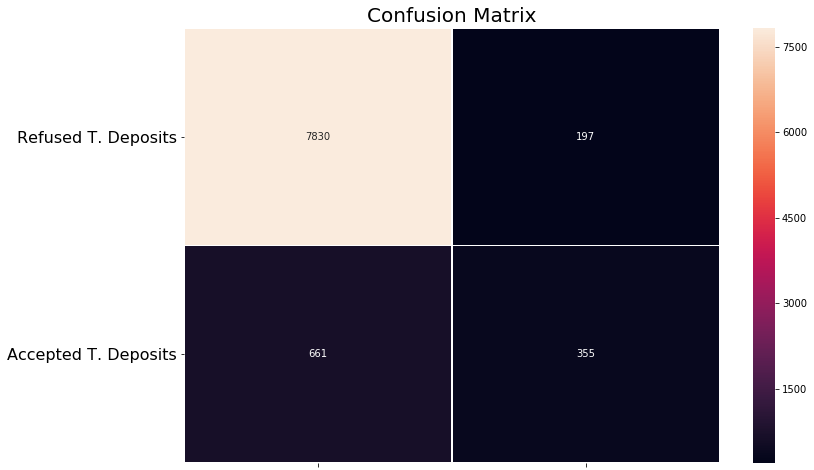

In [101]:
conf_matrix = confusion_matrix(y_test, y_predicted)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion Matrix", fontsize=20)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels("")
ax.set_yticklabels(['Refused T. Deposits', 'Accepted T. Deposits'], fontsize=16, rotation=360)
plt.show()

**Positive** => 0 => Refused Term Deposits  
**Negative** => 1 => Accepted Term Deposits  

**True  Positive (TP)** => 7830  
**False Positive (FP)** => 197  

The model predicted 7830 CORRECTLY (Refused T. Deposits) and only 197 FALSELY predicted as Positive(0), which is not bad.  

**False Negative (FN)** => 661  
**True  Negative (TN)** => 335  

The model predicted 661 FALSELY as (1 - Accepted T. Deposits) and only 335 CORRECTLY predicted as "Accepted T. Deposits", which needs some more verification.

### 6.3 : Classification Report

In [80]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      8027
           1       0.64      0.35      0.45      1016

    accuracy                           0.91      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.91      0.89      9043



Classification report shows the precision, recall, F1 and support scores for the LR classification model.

Precision of 0 (the client said no) represents that for all instances predicted as no subscription, the percentage of clients that actually said no is 92%.  

Recall is the ability of a classifier to find all positive instances. Recall of 0 indicates that for all clients that actually said no, the model predicts 98% correctly that they would decline the offer.

### 6.4 : AUC-ROC Curve

ROC AUC: 0.892


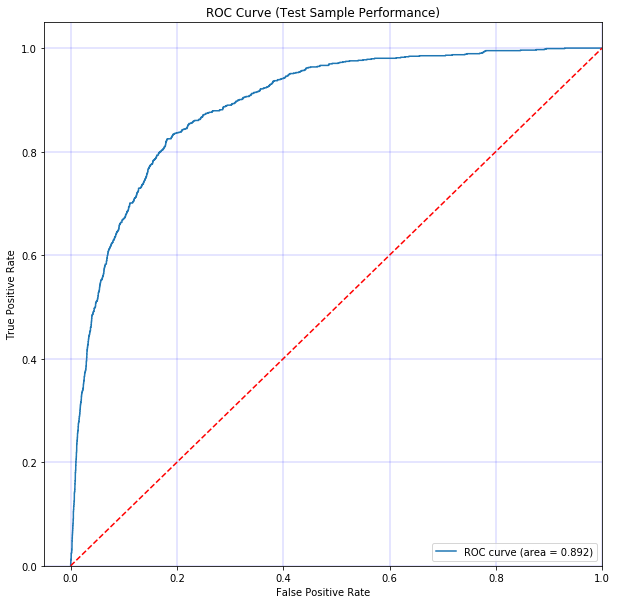

In [83]:
# Determine the false positive and true positive rates
FPR, TPR, _ = roc_curve(y_test, logmodel.predict_proba(x_test)[:,1])

# Calculate the AUC
roc_auc = auc(FPR, TPR)
print ('ROC AUC: %0.3f' % roc_auc )

# Plot of a ROC curve
plt.figure(figsize=(10,10))
plt.plot(FPR, TPR, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Sample Performance)')
plt.legend(loc="lower right")
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()

<div class="alert alert-block alert-success">
<font color=blue>

### 7. Prediction with new data

</font>
</div>

<div class="alert alert-block alert-success">
<font color=blue>

### 8. Conclusion

</font>
</div>

<div class="alert alert-block alert-success">
<font color=blue>

### References

</font>
</div>

- Dataset https://grouplens.org/datasets/movielens/100k/
